In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [4]:
#!pip install scikit-plot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os

In [5]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

In [6]:
df = pd.read_csv('./fer2013.csv/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [8]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [9]:
#sns.countplot(df.emotion)
#pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [10]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

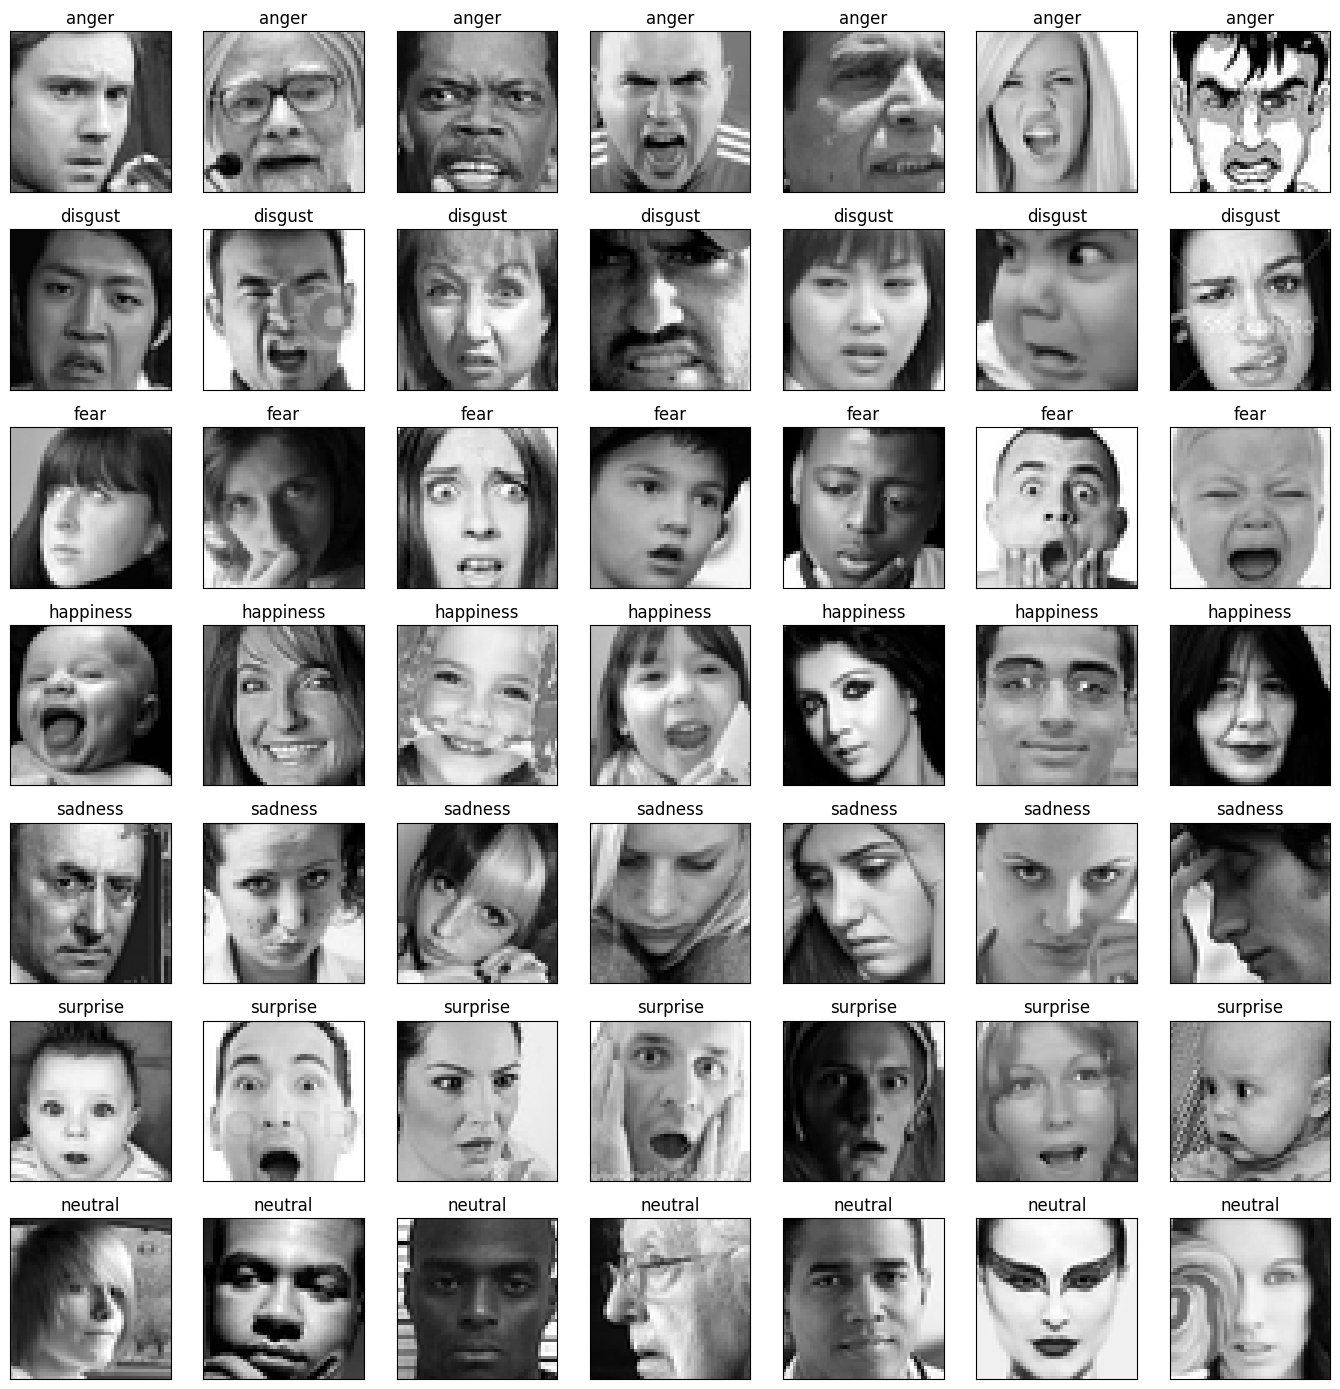

In [11]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [12]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
INTERESTED_LABELS = [0,2,3, 4]

In [13]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(25140, 3)

`Now I will make the data compatible for neural networks.`

In [14]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [15]:
img_array.shape

(25140, 48, 48, 1)

In [16]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(25140, 4)

In [17]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3}


`Splitting the data into training and validation set.`

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((22626, 48, 48, 1), (2514, 48, 48, 1), (22626, 4), (2514, 4))

In [19]:
del df
del img_array
del img_labels

In [20]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [21]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [22]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [23]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [24]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [25]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 20
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [33]:
model_yaml = model.to_json()
with open("model.json", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save_weights("model.h5")

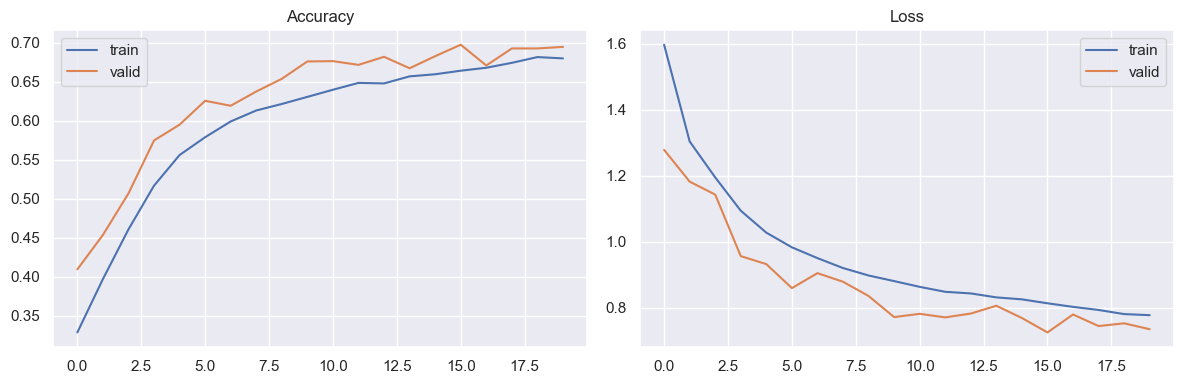

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de Accuracy
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=axes[0])
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=axes[0])
axes[0].set_title('Accuracy')

# Gráfico de Loss
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=axes[1])
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=axes[1])
axes[1].set_title('Loss')

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png')
plt.show()


In [39]:
'''sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()'''

"sns.set()\nfig = pyplot.figure(0, (12, 4))\n\nax = pyplot.subplot(1, 2, 1)\nsns.lineplot(history.epoch, history.history['accuracy'], label='train')\nsns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')\npyplot.title('Accuracy')\npyplot.tight_layout()\n\nax = pyplot.subplot(1, 2, 2)\nsns.lineplot(history.epoch, history.history['loss'], label='train')\nsns.lineplot(history.epoch, history.history['val_loss'], label='valid')\npyplot.title('Loss')\npyplot.tight_layout()\n\npyplot.savefig('epoch_history_dcnn.png')\npyplot.show()"

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

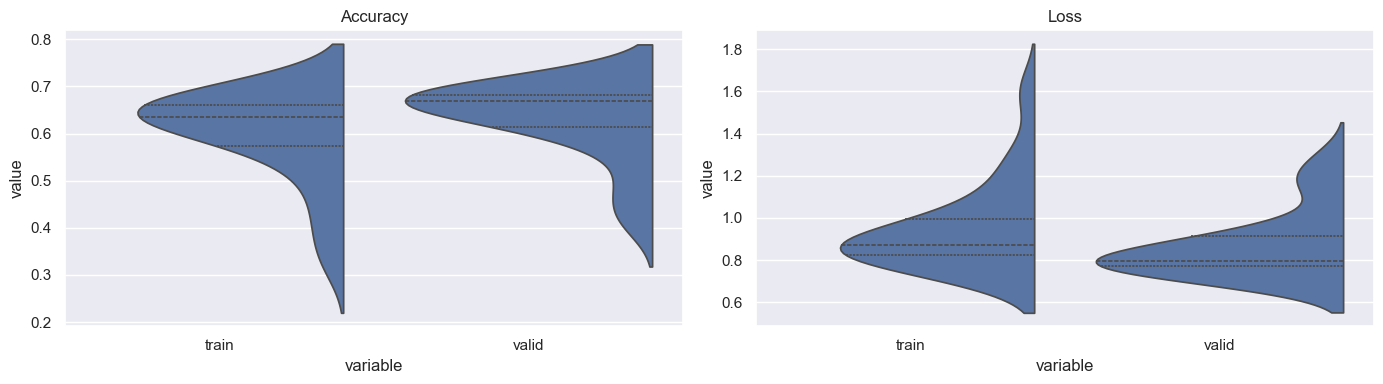

In [28]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))

ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), split=True, inner='quartile')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), split=True, inner='quartile')
plt.title('Loss')
plt.tight_layout()

plt.savefig('performance_dist.png')
plt.show()


In [42]:
'''df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()'''

'df_accu = pd.DataFrame({\'train\': history.history[\'accuracy\'], \'valid\': history.history[\'val_accuracy\']})\ndf_loss = pd.DataFrame({\'train\': history.history[\'loss\'], \'valid\': history.history[\'val_loss\']})\n\nfig = pyplot.figure(0, (14, 4))\nax = pyplot.subplot(1, 2, 1)\nsns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)\npyplot.title(\'Accuracy\')\npyplot.tight_layout()\n\nax = pyplot.subplot(1, 2, 2)\nsns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)\npyplot.title(\'Loss\')\npyplot.tight_layout()\n\npyplot.savefig(\'performance_dist.png\')\npyplot.show()'

79/79 [==============================] - 11s 141ms/step
total wrong validation predictions: 767


              precision    recall  f1-score   support

           0       0.62      0.60      0.61       495
           1       0.68      0.41      0.51       512
           2       0.92      0.86      0.89       899
           3       0.53      0.76      0.62       608

    accuracy                           0.69      2514
   macro avg       0.69      0.66      0.66      2514
weighted avg       0.72      0.69      0.69      2514



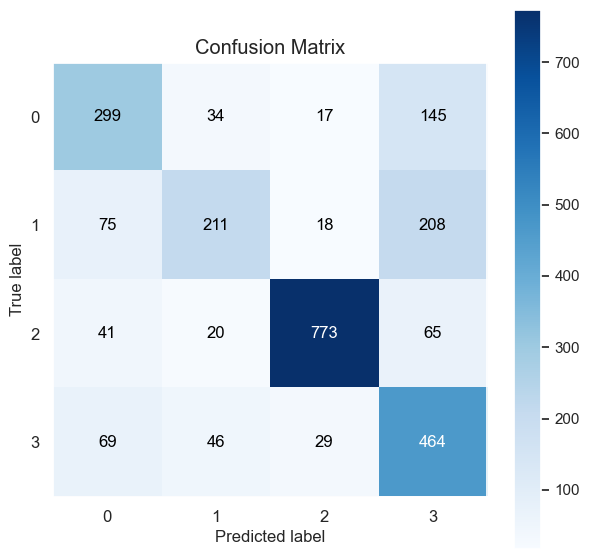

In [29]:
# Usar predict en lugar de predict_classes
yhat_valid_probs = model.predict(X_valid)

# Obtener las clases predichas
yhat_valid = np.argmax(yhat_valid_probs, axis=1)

# Plotear la matriz de confusión
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7, 7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))


In [45]:
'''yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))'''

'yhat_valid = model.predict_classes(X_valid)\nscikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))\npyplot.savefig("confusion_matrix_dcnn.png")\n\nprint(f\'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n\')\nprint(classification_report(np.argmax(y_valid, axis=1), yhat_valid))'

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [30]:
mapper = {
    0: "anger",
    1: "fear",
    2: "happy",
    3: "sad",
}


1/1 [==============================] - 0s 27ms/step


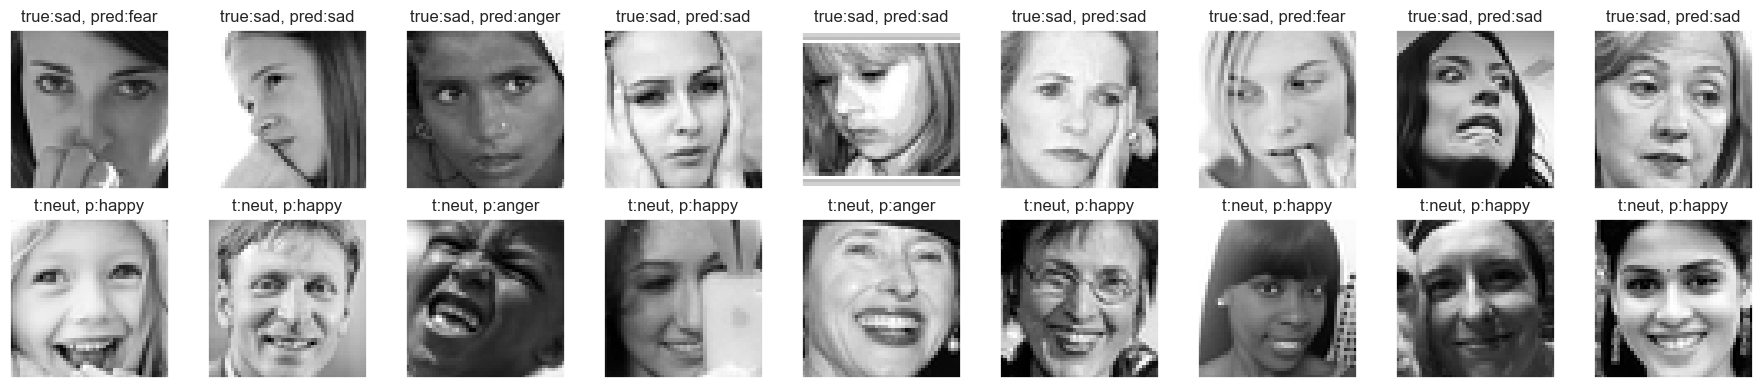

In [31]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Obtener las clases predichas utilizando el método predict y np.argmax
    predicted_class_sad = np.argmax(model.predict(sample_img.reshape(1,48,48,1)))

    ax.set_title(f"true:sad, pred:{mapper[predicted_class_sad]}")

    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Obtener las clases predichas utilizando el método predict y np.argmax
    predicted_class_neutral = np.argmax(model.predict(sample_img.reshape(1,48,48,1)))

    ax.set_title(f"t:neut, p:{mapper[predicted_class_neutral]}")

pyplot.tight_layout()


In [51]:
'''np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()'''

'np.random.seed(2)\nrandom_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)\nrandom_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)\n\nfig = pyplot.figure(1, (18, 4))\n\nfor i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):\n        ax = pyplot.subplot(2, 9, i+1)\n        sample_img = X_valid[sadidx,:,:,0]\n        ax.imshow(sample_img, cmap=\'gray\')\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.set_title(f"true:sad, pred:{mapper[model.predict(sample_img.reshape(1,48,48,1))[0]]}")\n\n        ax = pyplot.subplot(2, 9, i+10)\n        sample_img = X_valid[neuidx,:,:,0]\n        ax.imshow(sample_img, cmap=\'gray\')\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.set_title(f"t:neut, p:{mapper[model.predict(sample_img.reshape(1,48,48,1))[0]]}")\n\n        pyplot.tight_layout()'

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.

In [43]:
import cv2
import numpy as np
from tensorflow import keras

# Cargar el modelo desde el archivo YAML
with open("model.json", "r") as yaml_file:
    loaded_model_yaml = yaml_file.read()

loaded_model = keras.models.model_from_json(loaded_model_yaml)

# Cargar los pesos del modelo
loaded_model.load_weights("model.h5")

# Función para preprocesar la imagen antes de pasarla al modelo
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0  # Normalizar
    img = np.reshape(img, (1, 48, 48, 1))  # Agregar dimensión adicional para el batch
    return img

# Ruta de tu foto
#tu_foto_path = './caras/OIP.jpg'
#tu_foto_path = './caras/lobezno.jpg'
#tu_foto_path = './caras/miedo.jpg'
#tu_foto_path = './caras/triste.jpg'
tu_foto_path = './caras/doble.jpg'

# Preprocesar la foto
input_img = preprocess_image(tu_foto_path)

# Realizar la predicción
prediction = loaded_model.predict(input_img)

# Obtener la emoción predicha
predicted_class = np.argmax(prediction)

# Crear un diccionario para mapear clases a emociones (personaliza según tus clases)
mapper = {0: 'Anger', 1: 'Fear', 2: 'Happy', 3: 'Sad'}

# Imprimir la emoción predicha
print(f'Emoción predicha: {mapper[predicted_class]}')


1/1 [==============================] - 0s 126ms/step
Emoción predicha: Sad
